## **Import Libraries**

In [6]:
!pip install -r requirements.txt

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import torch
import wandb
import random
import numpy as np
import matplotlib.pyplot as plt

## **Getting Data**

In [5]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("aryanpandey1109/inaturalist12k")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/inaturalist12k
Dataset downloaded to: /kaggle/input/inaturalist12k


In [9]:
PROJECT = "DA6401_DL_Assignment2"
ENTITY = "karan"
COUNT = 200
DATA_PATH = path+"/Data/inaturalist_12K"

In [8]:
wandb.login(key="843913992a9025996973825be4ad46e4636d0610")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

## **Set GPU if available**

In [11]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.device(device)

## **Load Data**

In [12]:
def load_data(batch_size, img_size, augmentation="No", device="cpu", detailed_logs=1):
    base_transforms = [transforms.Resize((img_size, img_size))]

    if augmentation == "Yes":
        extra_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=30)
        ]
        base_transforms.extend(extra_transforms)

    training_pipeline = transforms.Compose([
        *base_transforms,
        transforms.ToTensor()
    ])

    evaluation_pipeline = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    training_set = datasets.ImageFolder(
        root=os.path.join(DATA_PATH, 'train'),
        transform=training_pipeline
    )
    testing_set = datasets.ImageFolder(
        root=os.path.join(DATA_PATH, 'val'),
        transform=evaluation_pipeline
    )

    total_train = len(training_set)
    train_subset_size = int(0.8 * total_train)
    validation_subset_size = total_train - train_subset_size

    train_split, valid_split = random_split(
        training_set,
        [train_subset_size, validation_subset_size]
    )

    loader_config = {
        'batch_size': batch_size,
        'shuffle': True
    }

    if device == "cuda":
        loader_config['num_workers'] = 4

    if detailed_logs:
        print("Dataset processing completed successfully")

    return (
        training_set.classes,
        DataLoader(train_split, **loader_config),
        DataLoader(valid_split, **loader_config),
        DataLoader(testing_set, **loader_config)
    )

## **Class ConvolutionalNeuralNetwork**

In [21]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, PARAM) -> None:
      super().__init__()
      self.detailed_logs = PARAM.get("detailed_logs", 0)
      if self.detailed_logs:
          print("Initializing CNN...")
      self.flatten = nn.Flatten()

      # Direct parameter assignments from PARAM
      self.filter_org = PARAM["filter_org"]
      self.filter_num = PARAM["filter_num"]
      self.con_layers = PARAM["con_layers"]
      self.den_layers = PARAM["dense_layers"]
      self.input_channel = PARAM["input_channel"]
      self.filter_size_list = PARAM["filter_size"]
      self.padding = PARAM["padding"]
      self.stride = PARAM["stride"]
      self.pool_padding = PARAM["pool_padding"]
      self.pool_stride = PARAM["pool_stride"]
      self.dense_output_list = PARAM["dense_output_list"]
      self.image_size = PARAM["image_size"]
      self.pool_filter_size = PARAM["pool_filter_size"]
      self.dropout_list = PARAM["dropout"]
      self.batch_norm = PARAM["batch_norm"]
      self.initialize = PARAM["init"]
      self.activation = PARAM["activation"]  # Retained for consistency

      # Derived attributes
      self.filter_num_list = self.organize_filters(
          self.filter_org, self.filter_num, self.con_layers
      )
      self.act = self.activation_fun(PARAM["activation"])
      self.output_act = self.activation_fun(PARAM["output_activation"])

      # Layer creation
      self.create_con_layers(
          self.input_channel,
          self.filter_size_list,
          self.dense_output_list,
          self.filter_num_list,
          self.act,
          self.pool_filter_size,
          self.output_act,
          self.image_size,
          self.dropout_list,
      )

    def create_con_layers(self, input_channel, filter_size_list, dense_output_list, filter_num_list, act, pool_filter_size, output_act, image_size, dropout_list):
      if self.detailed_logs:
          print("Creating convolutional layers...")
      self.layers = nn.ModuleList()
      computations = 0

      for idx in range(self.con_layers):
          filter_size = filter_size_list[idx]
          num_filters = filter_num_list[idx]

          conv = nn.Conv2d(input_channel, num_filters, filter_size,
                          padding=self.padding, stride=self.stride, bias=False)
          if self.initialize == "Xavier":
              nn.init.xavier_uniform_(conv.weight)

          modules = [conv]

          if self.batch_norm == "Yes":
              modules.append(nn.BatchNorm2d(num_filters))

          modules.append(act)
          modules.append(nn.MaxPool2d(pool_filter_size,
                                  padding=self.pool_padding, stride=self.pool_stride))

          if dropout_list[idx] != 0:
              modules.append(nn.Dropout(dropout_list[idx]))

          self.layers.append(nn.Sequential(*modules))

          post_conv_size = (image_size - filter_size + 2*self.padding) // self.stride + 1
          computations += (filter_size**2) * input_channel * (post_conv_size**2) * num_filters + num_filters

          image_size = (post_conv_size + 2*self.pool_padding - (pool_filter_size-1) - 1) // self.pool_stride + 1
          input_channel = num_filters  # Update input channels for next layer

      dense_input = input_channel * (image_size ** 2)
      for idx in range(self.den_layers):
          out_features = dense_output_list[idx]

          modules = [nn.Linear(dense_input, out_features), act]

          dropout_idx = self.con_layers + idx
          if dropout_list[dropout_idx] != 0:
              modules.append(nn.Dropout(dropout_list[dropout_idx]))

          self.layers.append(nn.Sequential(*modules))
          computations += (dense_input + 1) * out_features
          dense_input = out_features

      self.layers.append(nn.Sequential(
          nn.Linear(dense_input, 10),
          nn.Softmax(dim=1)
      ))
      computations += (dense_input + 1) * 10

      print("Total Computations:", computations)

    def organize_filters(self, filter_org, filter_number, layers):
      if self.detailed_logs:
          print("Organizing filters...")

      strategy_map = {
          "same": lambda l, fn: [fn] * l,
          "double": lambda l, fn: [fn * (2 ** i) for i in range(l)],
          "half": lambda l, fn: [int(fn * (2 ** (-i))) for i in range(l)],
          "alternating_list": lambda l, fn: [fn if i%2==0 else fn*2 for i in range(l)],
          "d_alternating_list": lambda l, fn: [fn if i%4 in {0,1} else fn*2 for i in range(l)],
          "desc": lambda l, fn: [fn - i for i in range(l)],
          "asc": lambda l, fn: [fn + i for i in range(l)]
      }

      if filter_org in strategy_map:
          return strategy_map[filter_org](layers, filter_number)

      return []

    def activation_fun(self, act):
      if self.detailed_logs:
          print(f"Setting activation function: {act}")

      activation_registry = [
          ("ReLU", nn.ReLU()),
          ("GELU", nn.GELU()),
          ("SiLU", nn.SiLU()),
          ("Mish", nn.Mish()),
          ("softmax", nn.Softmax(dim=1)),
          ("ELU", nn.ELU()),
          ("LeakyReLU", nn.LeakyReLU())
      ]

      for name, func in activation_registry:
          if name == act:
              return func

      return nn.ReLU()

    def forward(self, x):
      if self.detailed_logs:
          print("Forward pass started...")

      conv_section = self.layers[:self.con_layers]
      for conv_block in conv_section:
          x = conv_block(x)

      x = self.flatten(x)

      dense_section = self.layers[self.con_layers:self.con_layers + self.den_layers]
      for dense_block in dense_section:
          x = dense_block(x)

      output_layer = self.layers[-1]
      x = output_layer(x)

      if self.detailed_logs:
          print("Forward pass completed.")
      return x

    def set_optimizer(self, optimizer_name, learning_rate):
      if self.detailed_logs:
          print(f"Setting optimizer: {optimizer_name}")

      optimizer_registry = [
          ('sgd', optim.SGD),
          ('adam', optim.Adam),
          ('rmsprop', optim.RMSprop),
          ('nadam', optim.NAdam),
          ('adagrad', optim.Adagrad)
      ]

      for name, optimizer_class in optimizer_registry:
          if name == optimizer_name:
              self.optimizer = optimizer_class(self.parameters(), lr=learning_rate)
              break
      else:
          self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

      if self.detailed_logs:
          print("Optimizer set successfully.")
      return self.optimizer


## **Model Training**

In [22]:
def train_model(model, device, PARAM, console_log, wandb_log, return_model=0):
    detailed_logs = PARAM["detailed_logs"]

    criterion = nn.CrossEntropyLoss()
    optimizer = model.set_optimizer(PARAM["optimizer_name"], PARAM["eta"])
    labels, train_loader, val_loader, test_loader = load_data(
        PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"], device, PARAM["detailed_logs"]
    )

    patience = PARAM.get("early_stopping_patience", 5)
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(PARAM["epochs"]):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        if detailed_logs:
            print(f"Epoch {epoch+1} - Training started")

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if detailed_logs and batch_idx % 10 == 0:
                print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

        training_accuracy = 100 * correct / total
        model.eval()
        running_val_loss, correct_pred, total_pred = 0.0, 0, 0

        if detailed_logs:
            print("Validation started...")

        with torch.no_grad():
            for val_img, val_label in val_loader:
                val_img, val_label = val_img.to(device), val_label.to(device)
                val_output = model(val_img)
                loss_val = criterion(val_output, val_label)
                running_val_loss += loss_val.item()
                _, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        validation_accuracy = 100 * correct_pred / total_pred

        if console_log:
            print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {training_accuracy:.2f}%, Val Loss: {running_val_loss/len(val_loader):.4f}, Val Acc: {validation_accuracy:.2f}%")
            print("***********************************************************************************")

        if wandb_log:
            wandb.log({
                'epochs': epoch+1,
                'training_loss': running_loss/len(train_loader),
                'training_accuracy': training_accuracy,
                'validation_loss': running_val_loss/len(val_loader),
                'validation_accuracy': validation_accuracy
            })

        # Early Stopping Check
        if validation_accuracy > best_val_acc:
            best_val_acc = validation_accuracy
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            if console_log:
                print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model if return_model else best_val_acc

## **Set Parameters**

In [23]:
# init wandb if you want to set wandb log
device = set_device()
print("Currently Using :", device)

PARAM = {
    "con_layers": 5,
    "dense_layers": 1,
    "filter_size": [3, 3, 3, 3, 3],
    "output_activation": "softmax",
    "dense_output_list": [128],
    "filter_num": 32,
    "filter_org": "double",
    "activation": "ReLU",
    "input_channel": 3,
    "padding": 1,
    "stride": 1,
    "pool_padding": 0,
    "pool_stride": 2,
    "pool_filter_size": 2,
    "image_size": 128,
    "eta": 0.001,
    "dropout": [0.2, 0.3, 0.4, 0.5, 0.5, 0],
    "epochs": 20,
    "augmentation": "Yes",
    "batch_norm": "Yes",
    "init": "Xavier",
    "optimizer_name": "adam",
    "batch_size": 64,
    "detailed_logs": 0
}

net = ConvolutionalNeuralNetwork(PARAM).to(device)


accuracy_val = train_model(net, device, PARAM, 1, 0, 0)
print(accuracy_val)

Currently Using : cuda
Initializing CNN...
Organizing filters...
Setting activation function: ReLU
Setting activation function: softmax
Creating convolutional layers...
Total Computations: 317196650
Setting optimizer: adam
Optimizer set successfully.
Dataset processing completed successfully
Epoch 1 - Training started
Forward pass started...
Forward pass completed.
Batch 0: Loss = 2.2959
Forward pass started...
Forward pass completed.
Forward pass started...
Forward pass completed.
Forward pass started...
Forward pass completed.


KeyboardInterrupt: 

# **Question - 2**

In [35]:
sweep_config = {
    'name': 'ConvNet_Hyperparameter_Sweep',
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': 'Accuracy'},
    'parameters': {
        'epochs': {'values': [10]},
        'image_size': {'values': [224]},
        # Variable Parameters to Explore
        'batch_size': {'values': [32, 64]},
        'learning_rate': {'values': [1e-4, 3e-5, 1e-5]},
        'kernel': {'values': [32, 64]},
        'filter_org': {'values': ["same", "double", "half"]},
        'activation': {'values': ['ReLU', 'GELU', 'SiLU', 'Mish']},
        'data_augmentation': {'values': ["Yes", "No"]},
        'batch_norm': {'values': ["Yes", "No"]},
                'dropout': {
            'values': [
                [0, 0, 0, 0.2, 0.2, 0.3],
                [0, 0, 0.2, 0.2, 0.3, 0.5],
                [0.2, 0.2, 0.2, 0.3, 0.3, 0.5]
            ]
        },
        'dense_sizes': {'values': [256, 512]},
        'init': {'values': ['he_normal', 'xavier']}
    }
}

In [42]:
def train():
    run = wandb.init(project="DL-Assignment2")
    config = wandb.config

    run.name = (
        f"filt:{config.kernel}_org"{config.filter_org[:3]}_"
        f"bs:{config.batch_size}_lr:{config.learning_rate:.1e}_"
        f"act:{config.activation[:4]}_bn:{config.batch_norm}_"
        f"aug:{config.data_augmentation}_dout:{config.dropout[-1]}"
    )
    PARAM = {
        "con_layers": 5,
        "dense_layers": 1,
        "filter_num": config.kernel,
        "filter_org": config.filter_org,
        "filter_size": [3] * 5,
        "dense_output_list": [config.dense_sizes],
        "batch_size": config.batch_size,
        "eta": config.learning_rate,
        "epochs": config.epochs,
        "dropout": config.dropout,
        "batch_norm": config.batch_norm,
        "augmentation": config.data_augmentation,
        "image_size": config.image_size,
        "activation": config.activation,
        "output_activation": "softmax",
        "init": config.init,
        "input_channel": 3,
        "padding": 1,
        "stride": 1,
        "pool_filter_size": 2,
        "pool_stride": 2,
        "pool_padding": 0,
        "optimizer_name": 'adam',
        "detailed_logs": 0
    }

    model = ConvolutionalNeuralNetwork(PARAM).to(device)
    accuracy = train_model(
        model,
        device,
        PARAM,
        console_log=True,
        wandb_log=True,
        return_model=0
    )
    wandb.log({
                "accuracy" : accuracy
            })
    wandb.finish()


In [43]:
sweep_id = wandb.sweep(sweep_config, project = PROJECT)
wandb.agent(sweep_id, train, count = COUNT)
wandb.finish()

Create sweep with ID: u2p9c8gj
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_DL_Assignment2/sweeps/u2p9c8gj


wandb: Agent Starting Run: b65ap8y1 with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_norm: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: No
wandb: 	dense_sizes: 512
wandb: 	dropout: [0, 0, 0, 0, 0, 0]
wandb: 	epochs: 15
wandb: 	filter_size: 3
wandb: 	init: random
wandb: 	kernel: 64
wandb: 	kernel_aug: same
wandb: 	learning_rate: 3e-05


Total Computations: 702469962
Epoch 1, Train Loss: 2.2283, Train Acc: 21.34%, Val Loss: 2.1911, Val Acc: 25.60%
*****************************************************************************
Epoch 2, Train Loss: 2.1604, Train Acc: 30.09%, Val Loss: 2.1698, Val Acc: 27.50%
*****************************************************************************
Epoch 3, Train Loss: 2.1249, Train Acc: 33.73%, Val Loss: 2.1407, Val Acc: 31.85%
*****************************************************************************
Epoch 4, Train Loss: 2.1003, Train Acc: 36.42%, Val Loss: 2.1301, Val Acc: 32.90%
*****************************************************************************
Epoch 5, Train Loss: 2.0825, Train Acc: 38.22%, Val Loss: 2.1143, Val Acc: 34.80%
*****************************************************************************
Epoch 6, Train Loss: 2.0652, Train Acc: 40.14%, Val Loss: 2.1073, Val Acc: 35.00%
*****************************************************************************


wandb: Ctrl + C detected. Stopping sweep.


## **Question - 4**

In [34]:
# Best Config
PARAMS = {
    "con_layers" : 1,
    "dense_layers" : 1,
    "filter_size" : [3] * 5,
    "output_activation" : "softmax",
    "dense_output_list" : [256],
    "filter_num" : 64,
    "activation" : "ReLU",
    "filter_org" : "same", #double half
    "image_size" : 224,
    "pool_filter_size" : 2,
    "batch_size" : 32,
    "eta" : 0.0001,
    "dropout" : [0, 0, 0, 0, 0, 0.3],
    "epochs" : 1,#30,
    "augmentation" : "No",
    "batch_norm" : "Yes",
    "init" : "Random",
    "input_channel" : 3,
    "padding" : 1,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 2,
    "optimizer_name" : 'adam',
    "detailed_logs": 0
}

# New Model
model_best = ConvolutionalNeuralNetwork(PARAMS).to(device)

Total Computations: 292227914


In [35]:
# Train Model on Best Config
model_best = train_model(model_best, device, PARAMS, 1, 0, 1)

Epoch 1, Train Loss: 2.3611, Train Acc: 10.01%, Val Loss: 2.3614, Val Acc: 10.00%
***********************************************************************************


In [43]:
def evaluate_and_plot(model, test_loader, label, device, wandb_log=0, console_log=1, detailed_logs=0):
    model.eval()
    total, correct = 0, 0
    indices = random.sample(range(len(test_loader.dataset)), 30)
    plot_data = []

    for idx, (img, lbl) in enumerate(test_loader):
        img, lbl = img.to(device), lbl.to(device)
        with torch.no_grad():
            output = model(img)
            _, pred = torch.max(output, 1)
        correct += (pred == lbl).sum().item()
        total += lbl.size(0)
        if detailed_logs:
            print(f"Index: {idx}  True: {label[lbl.item()]} | Predicted: {label[pred.item()]}")

        if idx in indices:
            img_np = img.cpu().squeeze().permute(1, 2, 0)
            plot_data.append((img_np, lbl.item(), pred.item()))

    accuracy = correct / total if total else 0
    print(f"Accuracy: {accuracy}")

    fig, axes = plt.subplots(10, 3, figsize=(10, 30))
    correct_count = 0
    for i, (img, true, pred) in enumerate(plot_data):
        row, col = i // 3, i % 3
        axes[row, col].imshow(img)
        axes[row, col].axis('off')


        color = 'green' if true == pred else 'red'
        if true == pred:
            correct_count += 1

        axes[row, col].text(0.5, -0.05, f"Actual: {label[true]}",
                            ha='center', va='center', fontsize=12, fontweight='bold',
                            color='black', transform=axes[row, col].transAxes)
        axes[row, col].text(0.5, -0.12, f"Predicted: {label[pred]}",
                            ha='center', va='center', fontsize=12, fontweight='bold',
                            color=color, transform=axes[row, col].transAxes)



    plt.figtext(0.5, 0, f"Correct: {correct_count} out of 30", ha='center', fontsize=14, va='center',
                color='black', fontweight='bold')
    plt.subplots_adjust(hspace=0.6)
    plt.tight_layout()

    if wandb_log:
        import wandb
        wandb.init(project=PROJECT, name='PartA Q4: Grid 10 X 3')
        wandb.log({'Grid 10 X 3': wandb.Image(plt)})
        wandb.finish()

    if console_log:
        plt.show()

    return accuracy


Dataset processing completed successfully
Accuracy: 0.1


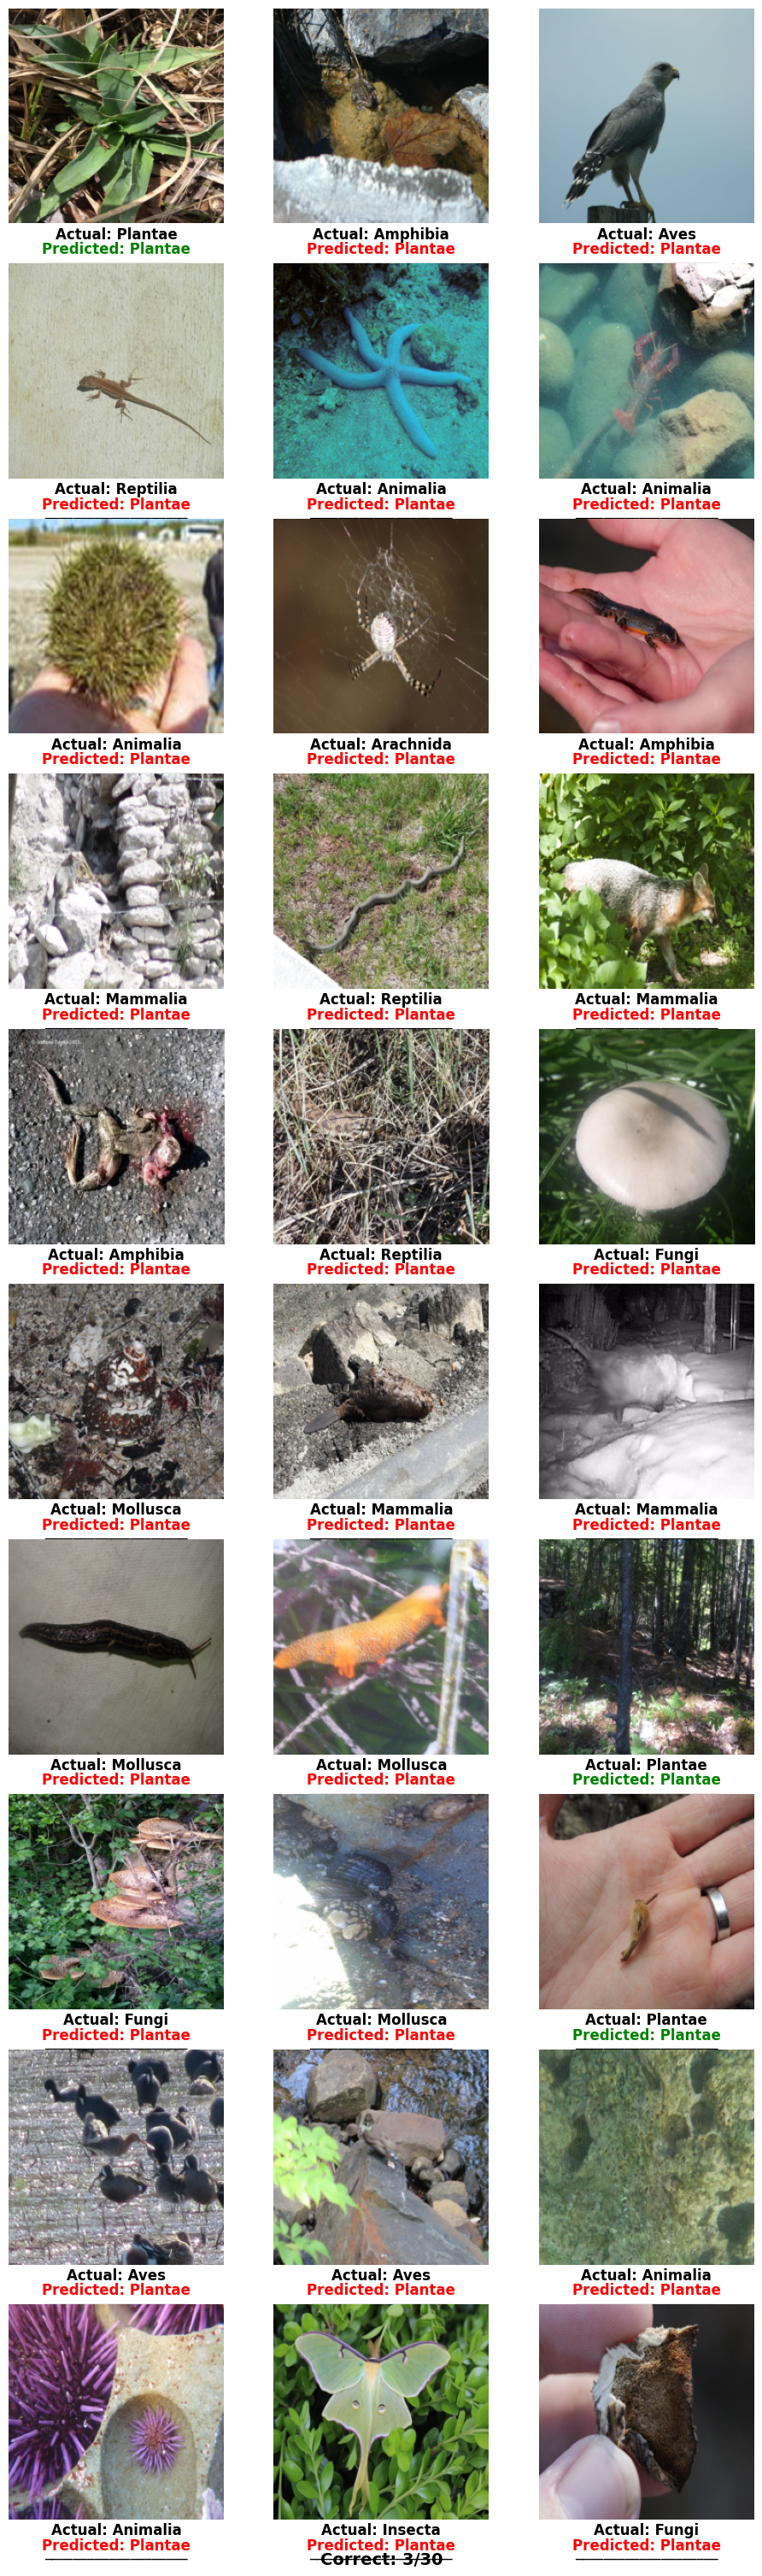

In [44]:
classes, train_loader, val_loader, test_loader = load_data(1, 224, device = device)

accuracy = evaluate_and_plot(
    model=model_best,
    test_loader=test_loader,
    label=classes,
    device=device
)